<a href="https://colab.research.google.com/github/BruunoRangel/BruunoRangel/blob/main/Exerc%C3%ADcio_Aula04_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nome: Bruno Rangel Balbino dos Santos 

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST


## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)


In [6]:
dta = list(dataset_train)
dta = list(zip(*dta))
print("shape= ",np.array(dta[0]).shape)
d = torch.stack(dta[0],dim=0)
print("shape d = ",np.array(d.shape))

shape=  (1000,)
shape d =  [1000    1   28   28]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing im

torch.Size([1, 28, 28])


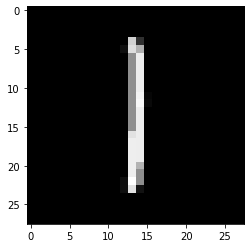

In [7]:
data0, y1 = dataset_train[0]
print(data0.shape)
plt.imshow(data0[0],cmap="gray")
plt.show()

N° total de imagens = 60000
Shape de cada imagem  torch.Size([28, 28])


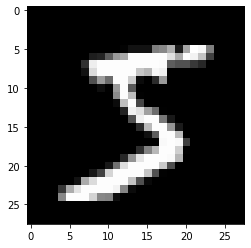

In [8]:
print("N° total de imagens =",dataset_train.dataset.data.shape[0])
print("Shape de cada imagem ",dataset_train.dataset.data[0].shape)
plt.imshow(dataset_train.dataset.data[0],cmap="gray")
plt.show()

In [9]:
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.batch_size = batch_size
        if shuffle == True:
            self.dataset = list(dataset)
            np.random.shuffle(self.dataset)
                     
          
        else:
            self.dataset = list(dataset)
            
            
    def __len__(self):
        return len(self.dataset)//self.batch_size + (len(self.dataset) % self.batch_size)
    
    def __iter__(self):
        self._index = 0
        return self

    def __next__(self):
        batch_size = self.batch_size
        if self._index >= len(self.dataset):
            raise StopIteration
        x = list(zip(*self.dataset))
        x[0] = torch.stack(x[0],dim=0) 
        c = 0 
        for batch_index in range(batch_size):
            data, target = self.dataset[batch_index + self._index]
            dados = x[0][batch_index+ self._index:batch_index+ self._index+1]
            if batch_index == 0:
                minibatch = dados
                batch_targets = torch.tensor([target])
            else:
                minibatch = torch.cat((minibatch, dados))
                batch_targets = torch.cat((batch_targets, torch.tensor([target])))
        self._index += batch_size
        return minibatch, batch_targets

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [427]:
# Escreva aqui o equivalente do código abaixo:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [10]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [11]:
class Model():
    def __init__(self, n_in: int, n_out: int):
        self.weights = torch.zeros(n_out,n_in, requires_grad=True) #iniciando os pesos com 0 
        self.bias = torch.ones(n_out, requires_grad=True) #iniciando as bias com 1 

    def __call__(self,mult):    
        y_pred = mult.mm(torch.t(self.weights))+self.bias.unsqueeze(0)
        return y_pred
    
    def parameters(self):
        return self.weights, self.bias

model = Model(28*28,10)


In [ ]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

## Treinamento

### Inicialização dos parâmetros

In [12]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [ ]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

In [13]:
class CrossEntropyLoss:
    def __init__(self):
        self.loss = 0

    def __call__(self,outputs, targets):   
        exp_x = torch.exp(outputs)
        sum_x = torch.sum(exp_x, dim=1, keepdim=True)

        batch_size = outputs.shape[0]
        outputs = torch.log(exp_x/sum_x)
        outputs = outputs[range(batch_size), targets]

        return -torch.sum(outputs)/batch_size

criterion = CrossEntropyLoss()

# Definição do Optimizer

In [ ]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

In [14]:
class SGD():
    def __init__(self, parameters: tuple, learning_rate: float):
        self.parameters = parameters
        self.lr = learning_rate
        

    def step(self):
        for parameter in self.parameters:
            parameter.data = (parameter.data - self.lr * parameter.grad).detach()

    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad = torch.zeros_like(parameter.data) 

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [15]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    loader_train = DataLoader(dataset_train, batch_size=50, shuffle=False)
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)
       

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786613464355
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.47862708568573
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.43632179498672485
Epoch: 10/49 Loss: 0.4191650450229645
Epoch: 11/49 Loss: 0.4039044976234436
Epoch: 12/49 Loss: 0.3901680111885071
Epoch: 13/49 Loss: 0.3776799142360687
Epoch: 14/49 Loss: 0.3662314713001251
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667418360710144
Epoch: 18/49 Loss: 0.32807353138923645
Epoch: 19/49 Loss: 0.31997355818748474
Epoch: 20/49 Loss: 0.312318354845047
Epoch: 21/49 Loss: 0.30506110191345215
Epoch: 22/49 Loss: 0.29816246032714844
Epoch: 23/49 Loss: 0.2915884852409363
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.27930304408073425
Epoch: 26/49 Los

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

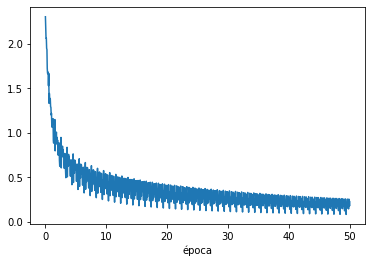

In [16]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

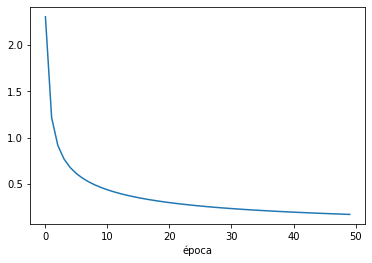

In [17]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [18]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [37]:
# Escreva o código aqui:
load_test = DataLoader(dataset_train, batch_size)

for x_test, y_test in loader_train:
  input = x_test.view(-1, 28 * 28)

  output = model(inputs)

  exp = torch.exp(output)
  soma = torch.sum(exp, dim=1, keepdim=True)
  prob = (exp/soma).detach().numpy()

  pred = np.argmax(prob, axis = 1)
  correct = np.where(pred==y_test.numpy())[0]
  wrong = np.where(pred!=y_test.numpy())[0]

In [36]:
# Qual é a amostra classificada corretamente, com maior probabilidade?
prob1 = np.argmax(prob[correct,pred[correct]])
print('Amostra classificada corretamente, com maior probabilidade: Amostra ', correct[prob1], 'com probabilidade =', prob[correct, pred[correct]][prob1],'\n')

# Qual é a amostra classificada erradamente, com maior probabilidade?
prob2 = np.argmax(prob[wrong,pred[wrong]])
print('Amostra classificada erradamente, com maior probabilidade: Amostra ', wrong[prob2], 'com probabilidade =',  prob[wrong,pred[wrong]][prob2],'\n')

#Qual é a amostra classificada corretamente, com menor probabilidade?
prob3 = np.argmin(prob[correct,pred[correct]])
print('Amostra classificada corretamente, com menor probabilidade: Amostra ', correct[prob3], 'com probabilidade =',  prob[correct,pred[correct]][prob3],'\n')

#Qual é a amostra classificada erradamente, com menor probabilidade?
prob4 = np.argmin(prob[wrong,pred[wrong]])
print('Amostra classificada erradamente, com menor probabilidade: Amostra ', wrong[prob4], 'com probabilidade =', prob[wrong,pred[wrong]][prob4])

Amostra classificada corretamente, com maior probabilidade: Amostra  10 com probabilidade = 0.9995435 

Amostra classificada erradamente, com maior probabilidade: Amostra  32 com probabilidade = 0.5242192 

Amostra classificada corretamente, com menor probabilidade: Amostra  49 com probabilidade = 0.44311965 

Amostra classificada erradamente, com menor probabilidade: Amostra  17 com probabilidade = 0.375853


## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
